<a href="https://colab.research.google.com/github/average81/KION/blob/scene_segmentation/hakaton3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Код выполняет полную pipeline-автоматизацию:

    загрузка видео,

    выделение аудио,

    анализ аудио и видео для определения сцен,

    интеллектуальное объединение сцен на основе аудио и видео весов,

    трекинг объектов в видео,

    распознавание речи и получение субтитров,

    финальная сегментация сцен с богатыми метаданными (объекты, текст),

    визуализация сценообразования,

    сохранение сцен отдельными видеофайлами,

    создание подробного отчёта по сценам.


In [ ]:
!python -m spacy download ru_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 23.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python pytube moviepy pydub scenedetect[opencv] transformers
!pip install -q ultralytics
!pip install -q git+https://github.com/facebookresearch/detectron2.git
!pip install -q librosa pandas matplotlib seaborn
!pip install -q speechrecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
from datetime import timedelta

# Видео обработка
from pytube import YouTube
from moviepy.editor import VideoFileClip
import scenedetect
from scenedetect.detectors import ContentDetector
from scenedetect.scene_manager import SceneManager

# Аудио обработка
import librosa
import librosa.display
from pydub import AudioSegment
import speech_recognition as sr

# Обработка субтитров
from transformers import pipeline
import spacy
from dataclasses import dataclass
from typing import List, Tuple
import re
from statistics import mean

# Детекция и трекинг объектов
from ultralytics import YOLO
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def download_youtube_video(url, output_path='./video.mp4'):
    yt = YouTube(url)
    stream = yt.streams.filter(file_extension='mp4', progressive=True).order_by('resolution').desc().first()
    stream.download(output_path=os.path.dirname(output_path), filename=os.path.basename(output_path))
    return output_path

# Пример использования (раскомментируйте для загрузки своего видео)
# video_path = download_youtube_video('https://www.youtube.com/watch?v=...')
# Или используйте свое видео
video_path = 'mister-i-missis-smit-2005.mp4'

Функция для извлечения аудио из видео

In [ ]:
# альтернативный путь, если в видео ошибки или проблемные метаданные
import subprocess

def extract_audio_with_ffmpeg(video_path, audio_path='audio.wav'):
    import subprocess

    cmd = ['ffmpeg', '-i', video_path, '-vn', '-acodec', 'pcm_s16le', audio_path]
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = proc.communicate()
    try:
        print(err.decode('utf-8'))
    except UnicodeDecodeError:
        print(err.decode('latin-1'))
    return audio_path


audio_path = extract_audio_with_ffmpeg('mister-i-missis-smit-2005.mp4')

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
def extract_audio(video_path, audio_path='audio.wav'):
    video = VideoFileClip(video_path)
    audio = video.audio
    audio.write_audiofile(audio_path, codec='pcm_s16le')
    return audio_path

audio_path = extract_audio(video_path)

MoviePy - Writing audio in audio.wav


chunk: 100%|█████████▉| 158645/158718 [01:11<00:00, 2533.00it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/audio/io/readers.py:197: UserWarning: Error in file mister-i-missis-smit-2005.mp4, At time t=7197.57-7197.62 seconds, indices wanted: 100000-101999, but len(buffer)=100001
index 100001 is out of bounds for axis 0 with size 100001
  warnings.warn("Error in file %s, "%(self.filename)+

index 100001 is out of bounds for axis 0 with size 100001
  warnings.warn("Error in file %s, "%(self.filename)+

index 100001 is out of bounds for axis 0 with size 100001
  warnings.warn("Error in file %s, "%(self.filename)+

index 100001 is out of bounds for axis 0 with size 100001
  warnings.warn("Error in file %s, "%(self.filename)+

index 100001 is out of bounds for axis 0 with size 100001
  warnings.warn("Error in file %s, "%(self.filename)+

index 100001 is out of bounds for axis 0 with size 100001
  warnings.warn("Error in file %s, "%(self.filename)+

index 10

MoviePy - Done.


Анализ аудио для обнаружения сцен

Вычисляет аудиохарактеристики по окнам:

    Нормализованная энергия RMS (Root Mean Square).

    Нормализованный спектральный центроид (характеристика частотного распределения).

    Zero Crossing Rate — количество пересечений аудиоволны с нулём (важно для различения тонов и шума).



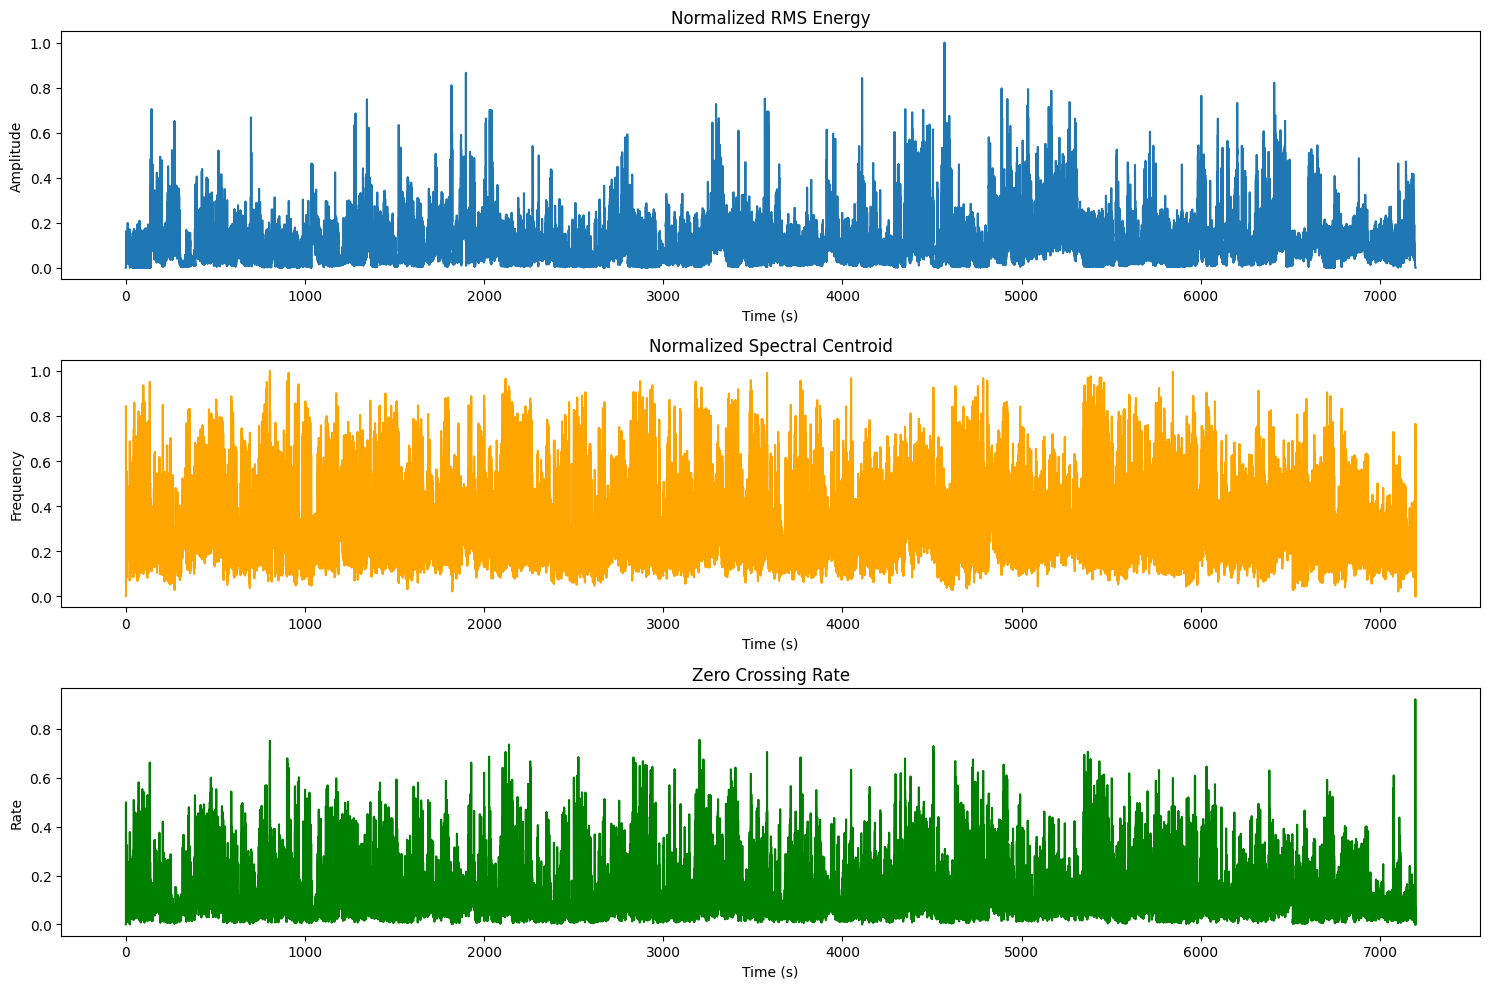

In [ ]:
def analyze_audio(audio_path, frame_length=2048, hop_length=512):
    # Загрузка аудио
    y, sr = librosa.load(audio_path)

    # Вычисление RMS энергии
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]

    # Нормализация
    rms_normalized = (rms - np.min(rms)) / (np.max(rms) - np.min(rms))

    # Вычисление спектрального центроида
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length)[0]
    spectral_centroid_normalized = (spectral_centroid - np.min(spectral_centroid)) / (np.max(spectral_centroid) - np.min(spectral_centroid))

    # Вычисление zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)[0]

    # Временная ось в секундах
    times = librosa.times_like(rms, sr=sr, hop_length=hop_length, n_fft=frame_length)

    return {
        'times': times,
        'rms': rms_normalized,
        'spectral_centroid': spectral_centroid_normalized,
        'zcr': zcr
    }

audio_features = analyze_audio(audio_path)

# Визуализация аудио признаков
def plot_audio_features(audio_features):
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(audio_features['times'], audio_features['rms'], label='RMS Energy')
    plt.title('Normalized RMS Energy')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.plot(audio_features['times'], audio_features['spectral_centroid'], label='Spectral Centroid', color='orange')
    plt.title('Normalized Spectral Centroid')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency')

    plt.subplot(3, 1, 3)
    plt.plot(audio_features['times'], audio_features['zcr'], label='Zero Crossing Rate', color='green')
    plt.title('Zero Crossing Rate')
    plt.xlabel('Time (s)')
    plt.ylabel('Rate')

    plt.tight_layout()
    plt.show()

plot_audio_features(audio_features)

Обнаружение сцен на основе видео контента

In [ ]:
def detect_video_scenes(video_path, threshold=30.0):
    # Создаем менеджер сцен и детектор
    video = scenedetect.VideoManager([video_path])
    scene_manager = SceneManager()
    scene_manager.add_detector(ContentDetector(threshold=threshold))

    # Обрабатываем видео
    video.set_downscale_factor()
    video.start()
    scene_manager.detect_scenes(frame_source=video)

    # Получаем список сцен
    scene_list = scene_manager.get_scene_list()

    # Конвертируем в секунды
    scenes = []
    for scene in scene_list:
        start_time = scene[0].get_seconds()
        end_time = scene[1].get_seconds()
        scenes.append((start_time, end_time))

    return scenes

video_scenes = detect_video_scenes(video_path)
print(f"Обнаружено {len(video_scenes)} сцен на основе видео контента:")
for i, (start, end) in enumerate(video_scenes):
    print(f"Сцена {i+1}: {start:.2f} - {end:.2f} сек")

ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 23.976 FPS, resolution: 720 x 304
INFO:pyscenedetect:Detecting scenes...


Обнаружено 1823 сцен на основе видео контента:
Сцена 1: 0.00 - 1.13 сек
Сцена 2: 1.13 - 2.21 сек
Сцена 3: 2.21 - 21.56 сек
Сцена 4: 21.56 - 38.04 сек
Сцена 5: 38.04 - 44.21 сек
Сцена 6: 44.21 - 47.21 сек
Сцена 7: 47.21 - 67.11 сек
Сцена 8: 67.11 - 70.20 сек
Сцена 9: 70.20 - 85.50 сек
Сцена 10: 85.50 - 88.51 сек
Сцена 11: 88.51 - 106.06 сек
Сцена 12: 106.06 - 109.11 сек
Сцена 13: 109.11 - 120.66 сек
Сцена 14: 120.66 - 124.67 сек
Сцена 15: 124.67 - 138.51 сек
Сцена 16: 138.51 - 146.19 сек
Сцена 17: 146.19 - 157.95 сек
Сцена 18: 157.95 - 160.91 сек
Сцена 19: 160.91 - 162.75 сек
Сцена 20: 162.75 - 164.66 сек
Сцена 21: 164.66 - 166.58 сек
Сцена 22: 166.58 - 169.38 сек
Сцена 23: 169.38 - 170.34 сек
Сцена 24: 170.34 - 171.30 сек
Сцена 25: 171.30 - 172.26 сек
Сцена 26: 172.26 - 172.92 сек
Сцена 27: 172.92 - 173.59 сек
Сцена 28: 173.59 - 174.30 сек
Сцена 29: 174.30 - 178.68 сек
Сцена 30: 178.68 - 180.43 сек
Сцена 31: 180.43 - 181.89 сек
Сцена 32: 181.89 - 183.56 сек
Сцена 33: 183.56 - 185.14 се

Обнаружение сцен на основе аудио

In [ ]:
def detect_audio_scenes(audio_features, rms_threshold=0.3, centroid_threshold=0.4, min_scene_duration=3.0):
    times = audio_features['times']
    rms = audio_features['rms']
    spectral_centroid = audio_features['spectral_centroid']

    scenes = []
    current_scene_start = 0.0

    for i in range(1, len(times)):
        # Проверяем изменения в RMS и спектральном центроиде
        rms_change = abs(rms[i] - rms[i-1])
        centroid_change = abs(spectral_centroid[i] - spectral_centroid[i-1])

        # Если изменения значительные, считаем это границей сцены
        if rms_change > rms_threshold or centroid_change > centroid_threshold:
            scene_duration = times[i] - current_scene_start
            if scene_duration >= min_scene_duration:
                scenes.append((current_scene_start, times[i]))
                current_scene_start = times[i]

    # Добавляем последнюю сцену
    if current_scene_start < times[-1]:
        scenes.append((current_scene_start, times[-1]))

    return scenes

audio_scenes = detect_audio_scenes(audio_features)
print(f"\nОбнаружено {len(audio_scenes)} сцен на основе аудио анализа:")
for i, (start, end) in enumerate(audio_scenes):
    print(f"Сцена {i+1}: {start:.2f} - {end:.2f} сек")


Обнаружено 81 сцен на основе аудио анализа:
Сцена 1: 0.00 - 97.90 сек
Сцена 2: 97.90 - 355.61 сек
Сцена 3: 355.61 - 451.23 сек
Сцена 4: 451.23 - 506.54 сек
Сцена 5: 506.54 - 591.27 сек
Сцена 6: 591.27 - 692.26 сек
Сцена 7: 692.26 - 779.63 сек
Сцена 8: 779.63 - 784.30 сек
Сцена 9: 784.30 - 899.73 сек
Сцена 10: 899.73 - 960.84 сек
Сцена 11: 960.84 - 1002.20 сек
Сцена 12: 1002.20 - 1014.48 сек
Сцена 13: 1014.48 - 1276.40 сек
Сцена 14: 1276.40 - 1282.32 сек
Сцена 15: 1282.32 - 1449.18 сек
Сцена 16: 1449.18 - 1463.25 сек
Сцена 17: 1463.25 - 1499.06 сек
Сцена 18: 1499.06 - 1507.93 сек
Сцена 19: 1507.93 - 1687.28 сек
Сцена 20: 1687.28 - 1799.01 сек
Сцена 21: 1799.01 - 2120.14 сек
Сцена 22: 2120.14 - 2138.53 сек
Сцена 23: 2138.53 - 2146.41 сек
Сцена 24: 2146.41 - 2151.63 сек
Сцена 25: 2151.63 - 2392.28 сек
Сцена 26: 2392.28 - 2471.97 сек
Сцена 27: 2471.97 - 2520.13 сек
Сцена 28: 2520.13 - 2555.22 сек
Сцена 29: 2555.22 - 2647.63 сек
Сцена 30: 2647.63 - 2872.01 сек
Сцена 31: 2872.01 - 2885.87 с

Объединение видео и аудио сцен

Для диалоговых сцен:


merge_scenes(video_scenes, audio_scenes,
            video_weight=0.4,  # меньше вес видео (частые смены кадров)
            audio_weight=0.6,  # больше вес аудио (диалог продолжается)
            max_scene_duration=90.0)
Для экшен-сцен:


merge_scenes(video_scenes, audio_scenes,
            video_weight=0.8,  # больше вес видео (важны визуальные изменения)
            audio_weight=0.2,
            max_scene_duration=30.0)
Балансный вариант:


merge_scenes(video_scenes, audio_scenes,
            video_weight=0.6,
            audio_weight=0.4,
            max_scene_duration=60.0)

            
Объединяет сцены с учётом весов, длительности, перекрытий и максимальной длительности.

In [ ]:
def merge_scenes(video_scenes, audio_scenes,
                video_weight=0.7, audio_weight=0.3,
                min_scene_duration=3.0, max_scene_duration=120.0,
                overlap_threshold=2.0):
    """
    Улучшенный алгоритм объединения сцен с учетом:
    - весовых коэффициентов для видео и аудио
    - минимальной и максимальной длительности сцен
    - сохранения логических границ
    """
    # Нормализуем и взвешиваем сцены
    weighted_scenes = []

    # Добавляем видео сцены с весом
    for start, end in video_scenes:
        duration = end - start
        if duration >= min_scene_duration:
            weighted_scenes.append({
                'start': start,
                'end': end,
                'weight': video_weight,
                'type': 'video'
            })

    # Добавляем аудио сцены с весом
    for start, end in audio_scenes:
        duration = end - start
        if duration >= min_scene_duration:
            weighted_scenes.append({
                'start': start,
                'end': end,
                'weight': audio_weight,
                'type': 'audio'
            })

    # Сортируем все сцены по времени начала
    weighted_scenes.sort(key=lambda x: x['start'])

    if not weighted_scenes:
        return []

    # Алгоритм интеллектуального объединения
    merged_scenes = []
    current_scene = weighted_scenes[0].copy()

    for scene in weighted_scenes[1:]:
        # Проверяем перекрытие или близость сцен
        scene_overlap = (scene['start'] <= current_scene['end'] + overlap_threshold)

        # Проверяем максимальную длительность
        duration_exceeded = (scene['end'] - current_scene['start']) > max_scene_duration

        # Если сцены пересекаются и не превышают максимальную длительность
        if scene_overlap and not duration_exceeded:
            # Объединяем сцены с учетом весов
            if scene['type'] == 'video' and current_scene['type'] != 'video':
                current_scene['end'] = scene['end']
                current_scene['weight'] += scene['weight']
                current_scene['type'] = 'mixed'
            elif scene['weight'] > current_scene['weight']:
                current_scene['end'] = scene['end']
                current_scene['weight'] += scene['weight']
                if scene['type'] != current_scene['type']:
                    current_scene['type'] = 'mixed'
            else:
                current_scene['end'] = max(current_scene['end'], scene['end'])
                current_scene['weight'] += scene['weight'] * 0.5  # меньший вес для расширения
        else:
            # Сохраняем текущую сцену и начинаем новую
            if current_scene['end'] - current_scene['start'] >= min_scene_duration:
                merged_scenes.append((current_scene['start'], current_scene['end']))
            current_scene = scene.copy()

    # Добавляем последнюю сцену
    if current_scene['end'] - current_scene['start'] >= min_scene_duration:
        merged_scenes.append((current_scene['start'], current_scene['end']))

    # Фильтруем слишком короткие сцены, которые могли появиться после объединения
    merged_scenes = [(start, end) for start, end in merged_scenes
                    if end - start >= min_scene_duration]

    return merged_scenes

Динамическое определение весов (не опробовано):

In [ ]:
"""def calculate_dynamic_weights(video_scenes, audio_scenes):
    # Анализируем распределение длительностей
    avg_video_duration = np.mean([end-start for start,end in video_scenes])
    avg_audio_duration = np.mean([end-start for start,end in audio_scenes])

    # Чем больше средняя длительность, тем меньше вес
    video_weight = min(0.8, 0.2 + 0.6*(1 - avg_video_duration/120))
    audio_weight = min(0.8, 0.2 + 0.6*(1 - avg_audio_duration/300))

    return video_weight, audio_weight

v_weight, a_weight = calculate_dynamic_weights(video_scenes, audio_scenes)"""

Постобработка для объединения слишком коротких сцен:

In [ ]:
def postprocess_scenes(scenes, min_duration=5.0):
    if not scenes:
        return []

    processed = []
    current_start, current_end = scenes[0]

    for start, end in scenes[1:]:
        if start - current_end < min_duration*2:  # близкие сцены
            current_end = end
        else:
            if current_end - current_start >= min_duration:
                processed.append((current_start, current_end))
            current_start, current_end = start, end

    if current_end - current_start >= min_duration:
        processed.append((current_start, current_end))

    return processed

Трекинг объектов с помощью YOLOv8 и DeepSORT

In [ ]:
# Загрузка модели YOLOv8
model = YOLO('yolov8l.pt')  # Используем большую модель для лучшей точности

# Функция для трекинга объектов в видео
def track_objects(video_path, output_path='output_tracked.mp4'):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Создаем VideoWriter для сохранения результата
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Словарь для хранения информации о треках
    tracks_info = defaultdict(list)

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Выполняем трекинг с YOLOv8
        results = model.track(frame, persist=True, tracker="bytetrack.yaml")

        # Визуализация результатов
        annotated_frame = results[0].plot()

        # Сохраняем информацию о треках
        if results[0].boxes.id is not None:
            for box, track_id in zip(results[0].boxes, results[0].boxes.id):
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                conf = box.conf[0].item()
                cls = box.cls[0].item()

                tracks_info[int(track_id)].append({
                    'frame': frame_count,
                    'time': frame_count / fps,
                    'bbox': [x1, y1, x2, y2],
                    'confidence': conf,
                    'class': cls
                })

        # Записываем кадр
        out.write(annotated_frame)
        frame_count += 1

    cap.release()
    out.release()

    return tracks_info, output_path

# Запускаем трекинг (может занять много времени)
tracks_info, tracked_video_path = track_objects(video_path)

100%|██████████| 83.7M/83.7M [00:00<00:00, 249MB/s]


Streaming output truncated to the last 5000 lines.
0: 288x640 (no detections), 18.7ms
Speed: 2.1ms preprocess, 18.7ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 (no detections), 17.8ms
Speed: 1.6ms preprocess, 17.8ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 (no detections), 19.9ms
Speed: 2.0ms preprocess, 19.9ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 (no detections), 19.0ms
Speed: 2.1ms preprocess, 19.0ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 (no detections), 18.0ms
Speed: 2.1ms preprocess, 18.0ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 (no detections), 18.9ms
Speed: 2.2ms preprocess, 18.9ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 (no detections), 18.0ms
Speed: 1.8ms preprocess, 18.0ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)

0: 288x640 (no det

Анализ субтитров (если доступны)

Загружается модель spaCy для русского языка (ru_core_news_md), чтобы анализировать смысл текста субтитров.

Считывается и парсится файл субтитров SRT.

Каждая реплика субтитров превращается в объект с таймкодами, текстом и лингвистическим представлением.

Реплики группируются в сцены на основе временных разрывов между репликами и семантической схожести текста.

Проводится дополнительное объединение сцен, чтобы избежать слишком коротких сцен или искусственного дробления.

Итоговые сцены выводятся на экран и сохраняются в текстовый файл.

In [ ]:
import re
from typing import List, Tuple
from dataclasses import dataclass
from statistics import mean
import spacy

# Настройки
MIN_SCENE_DURATION = 10.0  # Минимальная длительность сцены в секундах
TIME_GAP_THRESHOLD = 3.0  # Максимальный допустимый разрыв между репликами
SIMILARITY_THRESHOLD = 0.55  # Порог семантической схожести
MAX_SCENE_DURATION = 240.0  # Максимальная длительность одной сцены

# Загружаем модель для русского языка
try:
    nlp = spacy.load("ru_core_news_md")
except OSError:
    print("Модель ru_core_news_md не найдена. Установите её командой:")
    print("python -m spacy download ru_core_news_md")
    exit()

@dataclass
class SubtitleLine:
    index: int
    start: float  # в секундах
    end: float    # в секундах
    text: str
    doc: any = None  # spaCy Doc объект

def read_srt_file(file_path: str) -> str:
    """Читает содержимое файла SRT"""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except FileNotFoundError:
        print(f"Файл {file_path} не найден!")
        exit()
    except UnicodeDecodeError:
        try:
            with open(file_path, 'r', encoding='cp1251') as file:
                return file.read()
        except Exception as e:
            print(f"Ошибка при чтении файла: {e}")
            exit()

def parse_srt(srt_text: str) -> List[SubtitleLine]:
    subtitles = []
    blocks = re.split(r'\n\s*\n', srt_text.strip())

    for block in blocks:
        lines = block.strip().split('\n')
        if len(lines) < 3:
            continue

        try:
            index = int(lines[0])
            time_match = re.match(r'(\d{2}):(\d{2}):(\d{2}),(\d{3}) --> (\d{2}):(\d{2}):(\d{2}),(\d{3})', lines[1])
            if not time_match:
                continue

            h1, m1, s1, ms1 = map(int, time_match.groups()[:4])
            h2, m2, s2, ms2 = map(int, time_match.groups()[4:8])
            start = h1 * 3600 + m1 * 60 + s1 + ms1 / 1000
            end = h2 * 3600 + m2 * 60 + s2 + ms2 / 1000

            text = '\n'.join(lines[2:])
            doc = nlp(text)  # Анализируем текст с помощью spaCy
            subtitles.append(SubtitleLine(index, start, end, text, doc))
        except Exception as e:
            print(f"Ошибка при обработке блока: {e}")
            continue

    return subtitles

def calculate_scene_metrics(scene: List[SubtitleLine]) -> Tuple[float, float]:
    """Вычисляет длительность сцены и среднюю схожесть реплик"""
    if not scene:
        return 0.0, 0.0

    durations = [sub.end - sub.start for sub in scene]
    similarities = []

    for i in range(1, len(scene)):
        sim = scene[i-1].doc.similarity(scene[i].doc)
        similarities.append(sim)

    total_duration = scene[-1].end - scene[0].start
    avg_similarity = mean(similarities) if similarities else 1.0

    return total_duration, avg_similarity

def should_merge_scenes(prev_scene: List[SubtitleLine], current_scene: List[SubtitleLine]) -> bool:
    """Определяет, нужно ли объединять сцены"""
    if not prev_scene or not current_scene:
        return False

    # Проверяем временной промежуток между сценами
    time_gap = current_scene[0].start - prev_scene[-1].end

    # Проверяем схожесть последней реплики предыдущей сцены и первой текущей
    similarity = prev_scene[-1].doc.similarity(current_scene[0].doc)

    # Вычисляем общую длительность объединенной сцены
    merged_duration = current_scene[-1].end - prev_scene[0].start

    # Объединяем, если:
    # 1. Небольшой временной разрыв И хорошая схожесть
    # 2. ИЛИ если одна из сцен слишком короткая
    # 3. И при этом объединенная сцена не станет слишком длинной
    return ((time_gap <= TIME_GAP_THRESHOLD and similarity >= SIMILARITY_THRESHOLD) or
            any(calculate_scene_metrics(s)[0] < MIN_SCENE_DURATION for s in [prev_scene, current_scene])) and \
           merged_duration <= MAX_SCENE_DURATION

def group_into_scenes(subtitles: List[SubtitleLine]) -> List[Tuple[float, float]]:
    """Группирует субтитры в сцены и возвращает список кортежей (start, end)"""
    if not subtitles:
        return []

    # Сначала группируем по простым правилам
    initial_scenes = []
    current_scene = [subtitles[0]]

    for prev_sub, curr_sub in zip(subtitles, subtitles[1:]):
        time_gap = curr_sub.start - prev_sub.end
        similarity = prev_sub.doc.similarity(curr_sub.doc) if prev_sub.doc and curr_sub.doc else 0

        if time_gap > TIME_GAP_THRESHOLD or similarity < SIMILARITY_THRESHOLD:
            initial_scenes.append(current_scene)
            current_scene = [curr_sub]
        else:
            current_scene.append(curr_sub)

    initial_scenes.append(current_scene)

    # Затем объединяем короткие или связанные сцены
    merged_scenes = []

    for scene in initial_scenes:
        if not merged_scenes:
            merged_scenes.append(scene)
            continue

        if should_merge_scenes(merged_scenes[-1], scene):
            merged_scenes[-1].extend(scene)
        else:
            merged_scenes.append(scene)

    # Преобразуем в список кортежей (start, end) для совместимости со вторым кодом
    scene_boundaries = []
    for scene in merged_scenes:
        scene_start = scene[0].start
        scene_end = scene[-1].end
        scene_boundaries.append((scene_start, scene_end))

    return scene_boundaries

def prepare_subtitles_for_final(subtitles: List[SubtitleLine]) -> List[dict]:
    """Подготавливает субтитры для передачи в final_scene_segmentation"""
    return [{'start': sub.start, 'end': sub.end, 'text': sub.text} for sub in subtitles]

# Основной код
if __name__ == "__main__":
    # Укажите путь к вашему файлу субтитров
    srt_file_path = "Mr_And_Mrs_Smith_RUS_2005.srt"

    # Читаем файл
    srt_text = read_srt_file(srt_file_path)

    # Парсим и анализируем
    subtitles = parse_srt(srt_text)
    print(f"Обработано {len(subtitles)} реплик")

    # Получаем границы сцен
    merged_scenes = group_into_scenes(subtitles)
    print(f"Выделено {len(merged_scenes)} сцен")

    # Подготавливаем субтитры для передачи в final_scene_segmentation
    subtitles_for_final = prepare_subtitles_for_final(subtitles)

    # Выводим результат
    print("\nГраницы сцен по субтитрам:")
    for i, (start, end) in enumerate(merged_scenes, 1):
        print(f"Сцена {i}: {start:.2f} - {end:.2f} сек (длительность: {end-start:.2f} сек)")

  similarity = prev_sub.doc.similarity(curr_sub.doc) if prev_sub.doc and curr_sub.doc else 0

  similarity = prev_scene[-1].doc.similarity(current_scene[0].doc)

  sim = scene[i-1].doc.similarity(scene[i].doc)



Обработано 1079 реплик
Выделено 53 сцен

Границы сцен по субтитрам:
Сцена 1: 26.56 - 210.79 сек (длительность: 184.23 сек)
Сцена 2: 314.52 - 553.28 сек (длительность: 238.76 сек)
Сцена 3: 553.48 - 620.03 сек (длительность: 66.55 сек)
Сцена 4: 623.68 - 727.87 сек (длительность: 104.19 сек)
Сцена 5: 732.80 - 752.15 сек (длительность: 19.35 сек)
Сцена 6: 756.04 - 810.87 сек (длительность: 54.83 сек)
Сцена 7: 811.04 - 854.63 сек (длительность: 43.59 сек)
Сцена 8: 854.84 - 901.15 сек (длительность: 46.31 сек)
Сцена 9: 905.92 - 1093.55 сек (длительность: 187.63 сек)
Сцена 10: 1093.76 - 1332.91 сек (длительность: 239.15 сек)
Сцена 11: 1337.00 - 1404.36 сек (длительность: 67.36 сек)
Сцена 12: 1404.52 - 1566.24 сек (длительность: 161.72 сек)
Сцена 13: 1566.84 - 1782.27 сек (длительность: 215.43 сек)
Сцена 14: 1818.68 - 2005.63 сек (длительность: 186.95 сек)
Сцена 15: 2005.84 - 2025.68 сек (длительность: 19.84 сек)
Сцена 16: 2025.84 - 2092.60 сек (длительность: 66.76 сек)
Сцена 17: 2097.36 - 221

Объединение всех данных для финальной сегментации

In [ ]:
def final_scene_segmentation(merged_scenes, tracks_info, subtitles=None, min_scene_duration=5.0):
    final_scenes = []

    for scene_start, scene_end in merged_scenes:
        # Проверяем продолжительность сцены
        if scene_end - scene_start < min_scene_duration:
            continue

        # Анализируем объекты в сцене
        scene_tracks = {}
        for track_id, track_data in tracks_info.items():
            # Фильтруем объекты, которые находятся в текущей сцене
            objects_in_scene = [obj for obj in track_data if scene_start <= obj['time'] <= scene_end]
            if objects_in_scene:
                scene_tracks[track_id] = objects_in_scene

        # Анализируем субтитры (если есть)
        scene_text = ""
        if subtitles:
            for sub in subtitles:
                if scene_start <= sub['start'] <= scene_end or scene_start <= sub['end'] <= scene_end:
                    scene_text += sub['text'] + " "

        # Добавляем сцену в финальный список
        final_scenes.append({
            'start': scene_start,
            'end': scene_end,
            'duration': scene_end - scene_start,
            'objects': scene_tracks,
            'text': scene_text.strip() if scene_text else None
        })

    return final_scenes

# Вызываем функцию с реальными данными
final_scenes = final_scene_segmentation(merged_scenes, tracks_info, subtitles_for_final)

# Теперь можно выводить информацию
print("\nФинальная сегментация сцен:")
for i, scene in enumerate(final_scenes):
    print(f"\nСцена {i+1}:")
    print(f"Время: {scene['start']:.2f} - {scene['end']:.2f} сек (длительность: {scene['duration']:.2f} сек)")
    print(f"Количество уникальных объектов: {len(scene['objects'])}")
    if scene['text']:
        print(f"Текст: {scene['text'][:100]}...")


Финальная сегментация сцен:

Сцена 1:
Время: 26.56 - 210.79 сек (длительность: 184.23 сек)
Количество уникальных объектов: 272
Текст: - Давайте, я первый.
- Да. Я думаю, что зря мы сюда пришли. - Мы женаты уже пять лет.
- Шесть. Пять ...

Сцена 2:
Время: 314.52 - 553.28 сек (длительность: 238.76 сек)
Количество уникальных объектов: 802
Текст: Здравствуй. Привет. Доставка в номер. Приготовил, что смог. Спасибо. Вкусно. Пришлось козу доить,
чт...

Сцена 3:
Время: 553.48 - 620.03 сек (длительность: 66.55 сек)
Количество уникальных объектов: 166
Текст: Как тебе доктор Весли? Он выглядел
не слишком убедительно. Да, верно. И вопросы у него дурацкие. И е...

Сцена 4:
Время: 623.68 - 727.87 сек (длительность: 104.19 сек)
Количество уникальных объектов: 203
Текст: И куда это ты собрался? Ну, я... - Босс хотел меня видеть.
- Конечно. Он уже видит. Малыш, даже те,
...

Сцена 5:
Время: 732.80 - 752.15 сек (длительность: 19.35 сек)
Количество уникальных объектов: 39
Текст: Зубами вырвала
у одного 

Визуализация результатов

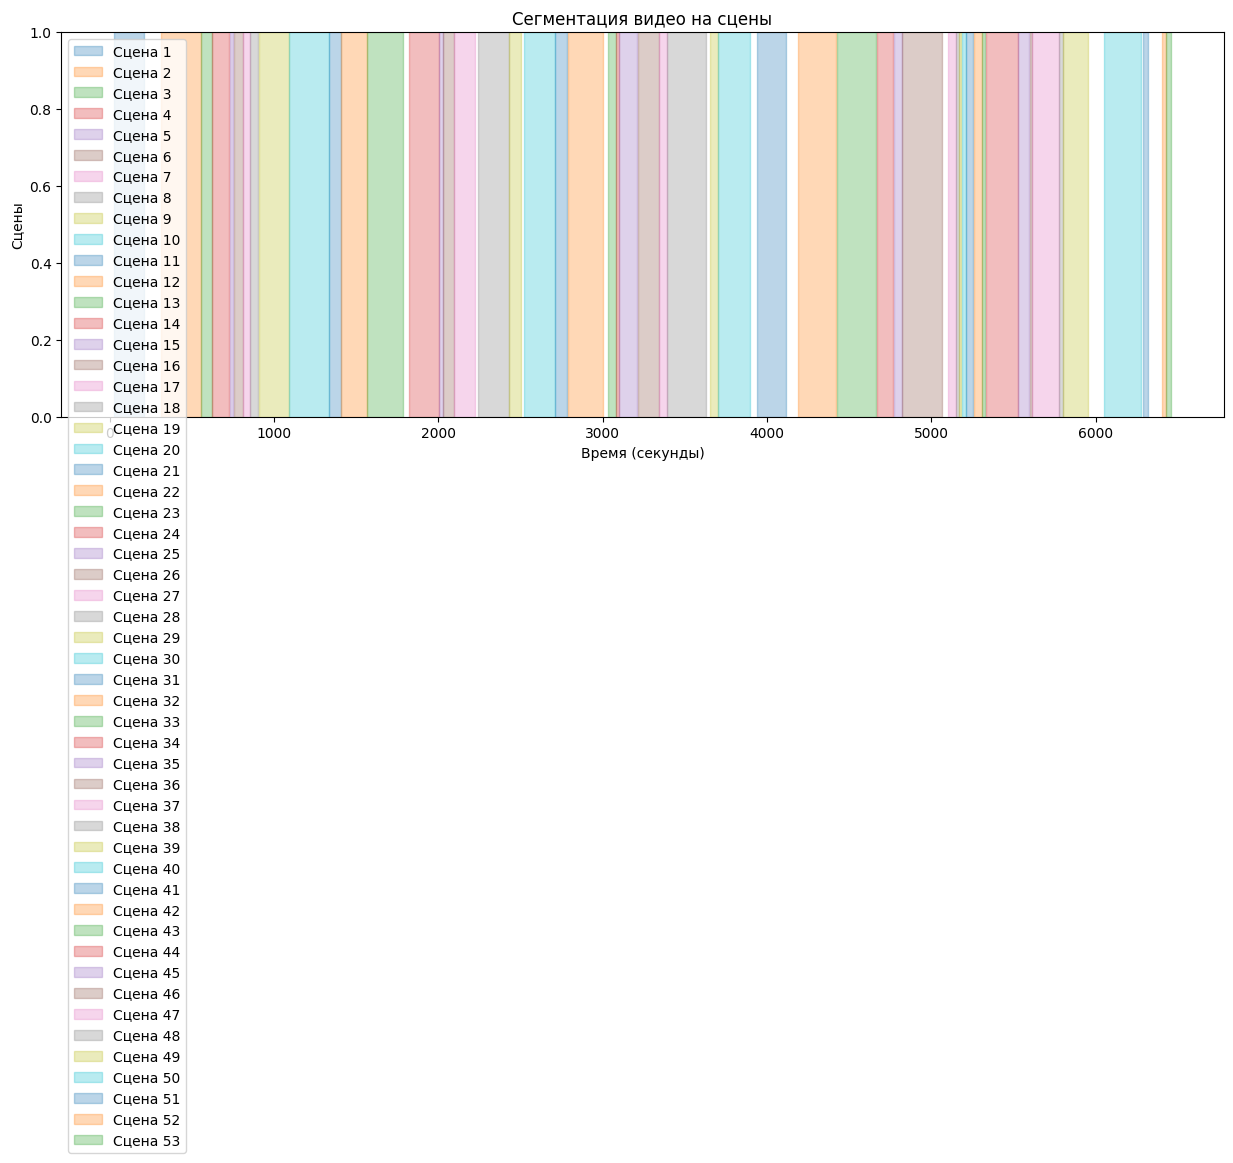

--------------------------------------
Обнаружено 296 сцен после улучшенного объединения:
Сцена 1: 0.00 - 47.21 сек (длительность: 47.21 сек)
Сцена 2: 47.21 - 106.06 сек (длительность: 58.85 сек)
Сцена 3: 97.90 - 146.19 сек (длительность: 48.29 сек)
Сцена 4: 146.19 - 157.95 сек (длительность: 11.76 сек)
Сцена 5: 174.30 - 178.68 сек (длительность: 4.38 сек)
Сцена 6: 185.14 - 189.94 сек (длительность: 4.80 сек)
Сцена 7: 197.11 - 223.56 сек (длительность: 26.44 сек)
Сцена 8: 225.98 - 238.32 сек (длительность: 12.35 сек)
Сцена 9: 241.57 - 247.96 сек (длительность: 6.38 сек)
Сцена 10: 250.08 - 253.42 сек (длительность: 3.34 сек)
Сцена 11: 267.68 - 272.36 сек (длительность: 4.67 сек)
Сцена 12: 276.15 - 279.28 сек (длительность: 3.13 сек)
Сцена 13: 283.83 - 313.23 сек (длительность: 29.40 сек)
Сцена 14: 315.44 - 356.77 сек (длительность: 41.33 сек)
Сцена 15: 355.61 - 370.16 сек (длительность: 14.55 сек)
Сцена 16: 372.21 - 395.60 сек (длительность: 23.40 сек)
Сцена 17: 397.73 - 423.51 сек (дли

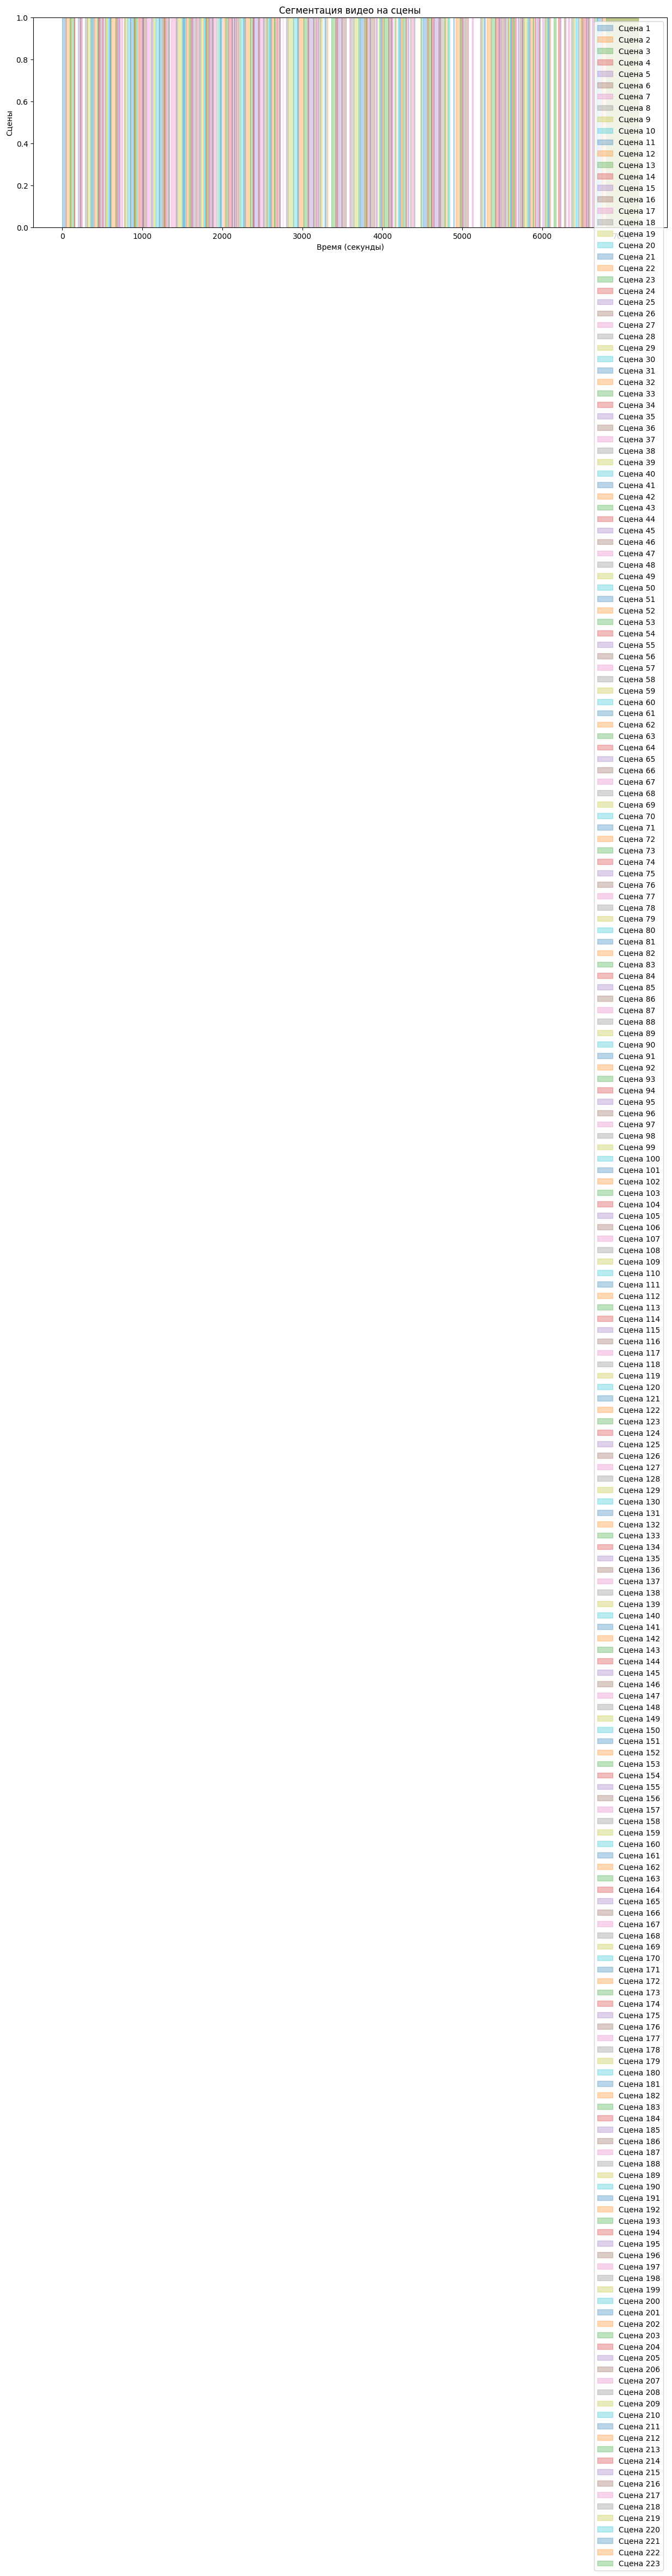

In [ ]:
def visualize_scenes(final_scenes, video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    plt.figure(figsize=(15, 5))

    # Создаем временную шкалу
    duration = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000
    time_axis = np.linspace(0, duration, 100)

    # Визуализируем сцены
    for i, scene in enumerate(final_scenes):
        plt.axvspan(scene['start'], scene['end'], alpha=0.3, color=f'C{i}', label=f'Сцена {i+1}')

    plt.title('Сегментация видео на сцены')
    plt.xlabel('Время (секунды)')
    plt.ylabel('Сцены')
    plt.legend()
    plt.show()

    cap.release()

visualize_scenes(final_scenes, video_path)

print("--------------------------------------")

# Параметры для нашего случая
video_weight = 0.7  # больший вес для видео сцен
audio_weight = 0.3  # меньший вес для аудио сцен
min_duration = 3.0  # минимальная длительность сцены в секундах
max_duration = 60.0 # максимальная длительность сцены в секундах

# Объединяем сцены с новыми параметрами
merged_scenes = merge_scenes(video_scenes, audio_scenes,
                           video_weight=video_weight,
                           audio_weight=audio_weight,
                           min_scene_duration=min_duration,
                           max_scene_duration=max_duration)

print(f"Обнаружено {len(merged_scenes)} сцен после улучшенного объединения:")
for i, (start, end) in enumerate(merged_scenes):
    print(f"Сцена {i+1}: {start:.2f} - {end:.2f} сек (длительность: {end-start:.2f} сек)")

# Финализируем сцены с трекингом объектов
final_scenes = final_scene_segmentation(merged_scenes, tracks_info)

# Визуализируем результат
visualize_scenes(final_scenes, video_path)

Сохранение сцен как отдельных видеофайлов

In [ ]:
def save_scenes_as_videos(video_path, final_scenes, output_dir='./scenes'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    video_name = os.path.splitext(os.path.basename(video_path))[0]

    for i, scene in enumerate(final_scenes):
        output_path = os.path.join(output_dir, f"{video_name}_scene_{i+1}.mp4")

        # Используем moviepy для вырезания сцены
        clip = VideoFileClip(video_path).subclip(scene['start'], scene['end'])
        clip.write_videofile(output_path, codec='libx264', audio_codec='aac')

        print(f"Сохранена сцена {i+1} в {output_path}")

save_scenes_as_videos(video_path, final_scenes)

Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_1.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_1TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_1.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_1.mp4
Сохранена сцена 1 в ./scenes/mister-i-missis-smit-2005_scene_1.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_2.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_2TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_2.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_2.mp4
Сохранена сцена 2 в ./scenes/mister-i-missis-smit-2005_scene_2.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_3.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_3TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_3.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_3.mp4
Сохранена сцена 3 в ./scenes/mister-i-missis-smit-2005_scene_3.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_4.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_4TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_4.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_4.mp4
Сохранена сцена 4 в ./scenes/mister-i-missis-smit-2005_scene_4.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_5.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_5TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_5.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_5.mp4
Сохранена сцена 5 в ./scenes/mister-i-missis-smit-2005_scene_5.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_6.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_6TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_6.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_6.mp4
Сохранена сцена 6 в ./scenes/mister-i-missis-smit-2005_scene_6.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_7.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_7TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_7.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_7.mp4
Сохранена сцена 7 в ./scenes/mister-i-missis-smit-2005_scene_7.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_8.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_8TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_8.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_8.mp4
Сохранена сцена 8 в ./scenes/mister-i-missis-smit-2005_scene_8.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_9.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_9TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_9.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_9.mp4
Сохранена сцена 9 в ./scenes/mister-i-missis-smit-2005_scene_9.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_10.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_10TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_10.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_10.mp4
Сохранена сцена 10 в ./scenes/mister-i-missis-smit-2005_scene_10.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_11.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_11TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_11.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_11.mp4
Сохранена сцена 11 в ./scenes/mister-i-missis-smit-2005_scene_11.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_12.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_12TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_12.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_12.mp4
Сохранена сцена 12 в ./scenes/mister-i-missis-smit-2005_scene_12.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_13.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_13TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_13.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_13.mp4
Сохранена сцена 13 в ./scenes/mister-i-missis-smit-2005_scene_13.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_14.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_14TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_14.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_14.mp4
Сохранена сцена 14 в ./scenes/mister-i-missis-smit-2005_scene_14.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_15.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_15TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_15.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_15.mp4
Сохранена сцена 15 в ./scenes/mister-i-missis-smit-2005_scene_15.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_16.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_16TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_16.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_16.mp4
Сохранена сцена 16 в ./scenes/mister-i-missis-smit-2005_scene_16.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_17.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_17TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_17.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_17.mp4
Сохранена сцена 17 в ./scenes/mister-i-missis-smit-2005_scene_17.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_18.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_18TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_18.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_18.mp4
Сохранена сцена 18 в ./scenes/mister-i-missis-smit-2005_scene_18.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_19.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_19TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_19.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_19.mp4
Сохранена сцена 19 в ./scenes/mister-i-missis-smit-2005_scene_19.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_20.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_20TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_20.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_20.mp4
Сохранена сцена 20 в ./scenes/mister-i-missis-smit-2005_scene_20.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_21.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_21TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_21.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_21.mp4
Сохранена сцена 21 в ./scenes/mister-i-missis-smit-2005_scene_21.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_22.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_22TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_22.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_22.mp4
Сохранена сцена 22 в ./scenes/mister-i-missis-smit-2005_scene_22.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_23.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_23TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_23.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_23.mp4
Сохранена сцена 23 в ./scenes/mister-i-missis-smit-2005_scene_23.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_24.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_24TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_24.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_24.mp4
Сохранена сцена 24 в ./scenes/mister-i-missis-smit-2005_scene_24.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_25.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_25TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_25.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_25.mp4
Сохранена сцена 25 в ./scenes/mister-i-missis-smit-2005_scene_25.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_26.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_26TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_26.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_26.mp4
Сохранена сцена 26 в ./scenes/mister-i-missis-smit-2005_scene_26.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_27.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_27TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_27.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_27.mp4
Сохранена сцена 27 в ./scenes/mister-i-missis-smit-2005_scene_27.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_28.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_28TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_28.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_28.mp4
Сохранена сцена 28 в ./scenes/mister-i-missis-smit-2005_scene_28.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_29.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_29TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_29.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_29.mp4
Сохранена сцена 29 в ./scenes/mister-i-missis-smit-2005_scene_29.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_30.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_30TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_30.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_30.mp4
Сохранена сцена 30 в ./scenes/mister-i-missis-smit-2005_scene_30.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_31.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_31TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_31.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_31.mp4
Сохранена сцена 31 в ./scenes/mister-i-missis-smit-2005_scene_31.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_32.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_32TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_32.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_32.mp4
Сохранена сцена 32 в ./scenes/mister-i-missis-smit-2005_scene_32.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_33.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_33TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_33.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_33.mp4
Сохранена сцена 33 в ./scenes/mister-i-missis-smit-2005_scene_33.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_34.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_34TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_34.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_34.mp4
Сохранена сцена 34 в ./scenes/mister-i-missis-smit-2005_scene_34.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_35.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_35TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_35.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_35.mp4
Сохранена сцена 35 в ./scenes/mister-i-missis-smit-2005_scene_35.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_36.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_36TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_36.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_36.mp4
Сохранена сцена 36 в ./scenes/mister-i-missis-smit-2005_scene_36.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_37.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_37TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_37.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_37.mp4
Сохранена сцена 37 в ./scenes/mister-i-missis-smit-2005_scene_37.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_38.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_38TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_38.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_38.mp4
Сохранена сцена 38 в ./scenes/mister-i-missis-smit-2005_scene_38.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_39.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_39TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_39.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_39.mp4
Сохранена сцена 39 в ./scenes/mister-i-missis-smit-2005_scene_39.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_40.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_40TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_40.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_40.mp4
Сохранена сцена 40 в ./scenes/mister-i-missis-smit-2005_scene_40.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_41.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_41TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_41.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_41.mp4
Сохранена сцена 41 в ./scenes/mister-i-missis-smit-2005_scene_41.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_42.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_42TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_42.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_42.mp4
Сохранена сцена 42 в ./scenes/mister-i-missis-smit-2005_scene_42.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_43.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_43TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_43.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_43.mp4
Сохранена сцена 43 в ./scenes/mister-i-missis-smit-2005_scene_43.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_44.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_44TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_44.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_44.mp4
Сохранена сцена 44 в ./scenes/mister-i-missis-smit-2005_scene_44.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_45.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_45TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_45.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_45.mp4
Сохранена сцена 45 в ./scenes/mister-i-missis-smit-2005_scene_45.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_46.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_46TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_46.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_46.mp4
Сохранена сцена 46 в ./scenes/mister-i-missis-smit-2005_scene_46.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_47.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_47TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_47.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_47.mp4
Сохранена сцена 47 в ./scenes/mister-i-missis-smit-2005_scene_47.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_48.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_48TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_48.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_48.mp4
Сохранена сцена 48 в ./scenes/mister-i-missis-smit-2005_scene_48.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_49.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_49TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_49.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_49.mp4
Сохранена сцена 49 в ./scenes/mister-i-missis-smit-2005_scene_49.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_50.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_50TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_50.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_50.mp4
Сохранена сцена 50 в ./scenes/mister-i-missis-smit-2005_scene_50.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_51.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_51TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_51.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_51.mp4
Сохранена сцена 51 в ./scenes/mister-i-missis-smit-2005_scene_51.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_52.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_52TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_52.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_52.mp4
Сохранена сцена 52 в ./scenes/mister-i-missis-smit-2005_scene_52.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_53.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_53TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_53.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_53.mp4
Сохранена сцена 53 в ./scenes/mister-i-missis-smit-2005_scene_53.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_54.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_54TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_54.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_54.mp4
Сохранена сцена 54 в ./scenes/mister-i-missis-smit-2005_scene_54.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_55.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_55TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_55.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_55.mp4
Сохранена сцена 55 в ./scenes/mister-i-missis-smit-2005_scene_55.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_56.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_56TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_56.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_56.mp4
Сохранена сцена 56 в ./scenes/mister-i-missis-smit-2005_scene_56.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_57.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_57TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_57.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_57.mp4
Сохранена сцена 57 в ./scenes/mister-i-missis-smit-2005_scene_57.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_58.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_58TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_58.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_58.mp4
Сохранена сцена 58 в ./scenes/mister-i-missis-smit-2005_scene_58.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_59.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_59TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_59.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_59.mp4
Сохранена сцена 59 в ./scenes/mister-i-missis-smit-2005_scene_59.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_60.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_60TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_60.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_60.mp4
Сохранена сцена 60 в ./scenes/mister-i-missis-smit-2005_scene_60.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_61.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_61TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_61.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_61.mp4
Сохранена сцена 61 в ./scenes/mister-i-missis-smit-2005_scene_61.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_62.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_62TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_62.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_62.mp4
Сохранена сцена 62 в ./scenes/mister-i-missis-smit-2005_scene_62.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_63.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_63TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_63.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_63.mp4
Сохранена сцена 63 в ./scenes/mister-i-missis-smit-2005_scene_63.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_64.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_64TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_64.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_64.mp4
Сохранена сцена 64 в ./scenes/mister-i-missis-smit-2005_scene_64.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_65.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_65TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_65.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_65.mp4
Сохранена сцена 65 в ./scenes/mister-i-missis-smit-2005_scene_65.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_66.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_66TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_66.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_66.mp4
Сохранена сцена 66 в ./scenes/mister-i-missis-smit-2005_scene_66.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_67.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_67TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_67.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_67.mp4
Сохранена сцена 67 в ./scenes/mister-i-missis-smit-2005_scene_67.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_68.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_68TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_68.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_68.mp4
Сохранена сцена 68 в ./scenes/mister-i-missis-smit-2005_scene_68.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_69.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_69TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_69.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_69.mp4
Сохранена сцена 69 в ./scenes/mister-i-missis-smit-2005_scene_69.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_70.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_70TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_70.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_70.mp4
Сохранена сцена 70 в ./scenes/mister-i-missis-smit-2005_scene_70.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_71.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_71TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_71.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_71.mp4
Сохранена сцена 71 в ./scenes/mister-i-missis-smit-2005_scene_71.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_72.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_72TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_72.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_72.mp4
Сохранена сцена 72 в ./scenes/mister-i-missis-smit-2005_scene_72.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_73.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_73TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_73.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_73.mp4
Сохранена сцена 73 в ./scenes/mister-i-missis-smit-2005_scene_73.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_74.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_74TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_74.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_74.mp4
Сохранена сцена 74 в ./scenes/mister-i-missis-smit-2005_scene_74.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_75.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_75TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_75.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_75.mp4
Сохранена сцена 75 в ./scenes/mister-i-missis-smit-2005_scene_75.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_76.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_76TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_76.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_76.mp4
Сохранена сцена 76 в ./scenes/mister-i-missis-smit-2005_scene_76.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_77.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_77TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_77.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_77.mp4
Сохранена сцена 77 в ./scenes/mister-i-missis-smit-2005_scene_77.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_78.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_78TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_78.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_78.mp4
Сохранена сцена 78 в ./scenes/mister-i-missis-smit-2005_scene_78.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_79.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_79TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_79.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_79.mp4
Сохранена сцена 79 в ./scenes/mister-i-missis-smit-2005_scene_79.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_80.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_80TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_80.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_80.mp4
Сохранена сцена 80 в ./scenes/mister-i-missis-smit-2005_scene_80.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_81.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_81TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_81.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_81.mp4
Сохранена сцена 81 в ./scenes/mister-i-missis-smit-2005_scene_81.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_82.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_82TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_82.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_82.mp4
Сохранена сцена 82 в ./scenes/mister-i-missis-smit-2005_scene_82.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_83.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_83TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_83.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_83.mp4
Сохранена сцена 83 в ./scenes/mister-i-missis-smit-2005_scene_83.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_84.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_84TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_84.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_84.mp4
Сохранена сцена 84 в ./scenes/mister-i-missis-smit-2005_scene_84.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_85.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_85TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_85.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_85.mp4
Сохранена сцена 85 в ./scenes/mister-i-missis-smit-2005_scene_85.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_86.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_86TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_86.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_86.mp4
Сохранена сцена 86 в ./scenes/mister-i-missis-smit-2005_scene_86.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_87.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_87TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_87.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_87.mp4
Сохранена сцена 87 в ./scenes/mister-i-missis-smit-2005_scene_87.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_88.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_88TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_88.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_88.mp4
Сохранена сцена 88 в ./scenes/mister-i-missis-smit-2005_scene_88.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_89.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_89TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_89.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_89.mp4
Сохранена сцена 89 в ./scenes/mister-i-missis-smit-2005_scene_89.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_90.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_90TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_90.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_90.mp4
Сохранена сцена 90 в ./scenes/mister-i-missis-smit-2005_scene_90.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_91.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_91TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_91.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_91.mp4
Сохранена сцена 91 в ./scenes/mister-i-missis-smit-2005_scene_91.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_92.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_92TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_92.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_92.mp4
Сохранена сцена 92 в ./scenes/mister-i-missis-smit-2005_scene_92.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_93.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_93TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_93.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_93.mp4
Сохранена сцена 93 в ./scenes/mister-i-missis-smit-2005_scene_93.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_94.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_94TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_94.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_94.mp4
Сохранена сцена 94 в ./scenes/mister-i-missis-smit-2005_scene_94.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_95.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_95TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_95.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_95.mp4
Сохранена сцена 95 в ./scenes/mister-i-missis-smit-2005_scene_95.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_96.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_96TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_96.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_96.mp4
Сохранена сцена 96 в ./scenes/mister-i-missis-smit-2005_scene_96.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_97.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_97TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_97.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_97.mp4
Сохранена сцена 97 в ./scenes/mister-i-missis-smit-2005_scene_97.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_98.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_98TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_98.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_98.mp4
Сохранена сцена 98 в ./scenes/mister-i-missis-smit-2005_scene_98.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_99.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_99TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_99.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_99.mp4
Сохранена сцена 99 в ./scenes/mister-i-missis-smit-2005_scene_99.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_100.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_100TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_100.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_100.mp4
Сохранена сцена 100 в ./scenes/mister-i-missis-smit-2005_scene_100.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_101.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_101TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_101.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_101.mp4
Сохранена сцена 101 в ./scenes/mister-i-missis-smit-2005_scene_101.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_102.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_102TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_102.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_102.mp4
Сохранена сцена 102 в ./scenes/mister-i-missis-smit-2005_scene_102.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_103.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_103TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_103.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_103.mp4
Сохранена сцена 103 в ./scenes/mister-i-missis-smit-2005_scene_103.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_104.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_104TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_104.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_104.mp4
Сохранена сцена 104 в ./scenes/mister-i-missis-smit-2005_scene_104.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_105.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_105TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_105.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_105.mp4
Сохранена сцена 105 в ./scenes/mister-i-missis-smit-2005_scene_105.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_106.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_106TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_106.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_106.mp4
Сохранена сцена 106 в ./scenes/mister-i-missis-smit-2005_scene_106.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_107.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_107TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_107.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_107.mp4
Сохранена сцена 107 в ./scenes/mister-i-missis-smit-2005_scene_107.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_108.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_108TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_108.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_108.mp4
Сохранена сцена 108 в ./scenes/mister-i-missis-smit-2005_scene_108.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_109.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_109TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_109.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_109.mp4
Сохранена сцена 109 в ./scenes/mister-i-missis-smit-2005_scene_109.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_110.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_110TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_110.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_110.mp4
Сохранена сцена 110 в ./scenes/mister-i-missis-smit-2005_scene_110.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_111.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_111TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_111.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_111.mp4
Сохранена сцена 111 в ./scenes/mister-i-missis-smit-2005_scene_111.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_112.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_112TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_112.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_112.mp4
Сохранена сцена 112 в ./scenes/mister-i-missis-smit-2005_scene_112.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_113.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_113TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_113.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_113.mp4
Сохранена сцена 113 в ./scenes/mister-i-missis-smit-2005_scene_113.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_114.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_114TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_114.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_114.mp4
Сохранена сцена 114 в ./scenes/mister-i-missis-smit-2005_scene_114.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_115.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_115TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_115.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_115.mp4
Сохранена сцена 115 в ./scenes/mister-i-missis-smit-2005_scene_115.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_116.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_116TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_116.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_116.mp4
Сохранена сцена 116 в ./scenes/mister-i-missis-smit-2005_scene_116.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_117.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_117TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_117.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_117.mp4
Сохранена сцена 117 в ./scenes/mister-i-missis-smit-2005_scene_117.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_118.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_118TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_118.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_118.mp4
Сохранена сцена 118 в ./scenes/mister-i-missis-smit-2005_scene_118.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_119.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_119TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_119.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_119.mp4
Сохранена сцена 119 в ./scenes/mister-i-missis-smit-2005_scene_119.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_120.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_120TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_120.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_120.mp4
Сохранена сцена 120 в ./scenes/mister-i-missis-smit-2005_scene_120.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_121.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_121TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_121.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_121.mp4
Сохранена сцена 121 в ./scenes/mister-i-missis-smit-2005_scene_121.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_122.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_122TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_122.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_122.mp4
Сохранена сцена 122 в ./scenes/mister-i-missis-smit-2005_scene_122.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_123.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_123TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_123.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_123.mp4
Сохранена сцена 123 в ./scenes/mister-i-missis-smit-2005_scene_123.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_124.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_124TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_124.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_124.mp4
Сохранена сцена 124 в ./scenes/mister-i-missis-smit-2005_scene_124.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_125.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_125TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_125.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_125.mp4
Сохранена сцена 125 в ./scenes/mister-i-missis-smit-2005_scene_125.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_126.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_126TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_126.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_126.mp4
Сохранена сцена 126 в ./scenes/mister-i-missis-smit-2005_scene_126.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_127.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_127TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_127.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_127.mp4
Сохранена сцена 127 в ./scenes/mister-i-missis-smit-2005_scene_127.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_128.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_128TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_128.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_128.mp4
Сохранена сцена 128 в ./scenes/mister-i-missis-smit-2005_scene_128.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_129.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_129TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_129.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_129.mp4
Сохранена сцена 129 в ./scenes/mister-i-missis-smit-2005_scene_129.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_130.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_130TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_130.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_130.mp4
Сохранена сцена 130 в ./scenes/mister-i-missis-smit-2005_scene_130.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_131.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_131TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_131.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_131.mp4
Сохранена сцена 131 в ./scenes/mister-i-missis-smit-2005_scene_131.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_132.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_132TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_132.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_132.mp4
Сохранена сцена 132 в ./scenes/mister-i-missis-smit-2005_scene_132.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_133.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_133TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_133.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_133.mp4
Сохранена сцена 133 в ./scenes/mister-i-missis-smit-2005_scene_133.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_134.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_134TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_134.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_134.mp4
Сохранена сцена 134 в ./scenes/mister-i-missis-smit-2005_scene_134.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_135.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_135TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_135.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_135.mp4
Сохранена сцена 135 в ./scenes/mister-i-missis-smit-2005_scene_135.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_136.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_136TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_136.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_136.mp4
Сохранена сцена 136 в ./scenes/mister-i-missis-smit-2005_scene_136.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_137.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_137TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_137.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_137.mp4
Сохранена сцена 137 в ./scenes/mister-i-missis-smit-2005_scene_137.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_138.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_138TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_138.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_138.mp4
Сохранена сцена 138 в ./scenes/mister-i-missis-smit-2005_scene_138.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_139.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_139TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_139.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_139.mp4
Сохранена сцена 139 в ./scenes/mister-i-missis-smit-2005_scene_139.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_140.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_140TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_140.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_140.mp4
Сохранена сцена 140 в ./scenes/mister-i-missis-smit-2005_scene_140.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_141.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_141TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_141.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_141.mp4
Сохранена сцена 141 в ./scenes/mister-i-missis-smit-2005_scene_141.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_142.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_142TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_142.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_142.mp4
Сохранена сцена 142 в ./scenes/mister-i-missis-smit-2005_scene_142.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_143.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_143TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_143.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_143.mp4
Сохранена сцена 143 в ./scenes/mister-i-missis-smit-2005_scene_143.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_144.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_144TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_144.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_144.mp4
Сохранена сцена 144 в ./scenes/mister-i-missis-smit-2005_scene_144.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_145.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_145TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_145.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_145.mp4
Сохранена сцена 145 в ./scenes/mister-i-missis-smit-2005_scene_145.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_146.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_146TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_146.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_146.mp4
Сохранена сцена 146 в ./scenes/mister-i-missis-smit-2005_scene_146.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_147.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_147TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_147.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_147.mp4
Сохранена сцена 147 в ./scenes/mister-i-missis-smit-2005_scene_147.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_148.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_148TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_148.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_148.mp4
Сохранена сцена 148 в ./scenes/mister-i-missis-smit-2005_scene_148.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_149.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_149TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_149.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_149.mp4
Сохранена сцена 149 в ./scenes/mister-i-missis-smit-2005_scene_149.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_150.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_150TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_150.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_150.mp4
Сохранена сцена 150 в ./scenes/mister-i-missis-smit-2005_scene_150.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_151.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_151TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_151.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_151.mp4
Сохранена сцена 151 в ./scenes/mister-i-missis-smit-2005_scene_151.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_152.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_152TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_152.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_152.mp4
Сохранена сцена 152 в ./scenes/mister-i-missis-smit-2005_scene_152.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_153.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_153TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_153.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_153.mp4
Сохранена сцена 153 в ./scenes/mister-i-missis-smit-2005_scene_153.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_154.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_154TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_154.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_154.mp4
Сохранена сцена 154 в ./scenes/mister-i-missis-smit-2005_scene_154.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_155.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_155TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_155.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_155.mp4
Сохранена сцена 155 в ./scenes/mister-i-missis-smit-2005_scene_155.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_156.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_156TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_156.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_156.mp4
Сохранена сцена 156 в ./scenes/mister-i-missis-smit-2005_scene_156.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_157.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_157TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_157.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_157.mp4
Сохранена сцена 157 в ./scenes/mister-i-missis-smit-2005_scene_157.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_158.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_158TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_158.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_158.mp4
Сохранена сцена 158 в ./scenes/mister-i-missis-smit-2005_scene_158.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_159.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_159TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_159.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_159.mp4
Сохранена сцена 159 в ./scenes/mister-i-missis-smit-2005_scene_159.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_160.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_160TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_160.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_160.mp4
Сохранена сцена 160 в ./scenes/mister-i-missis-smit-2005_scene_160.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_161.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_161TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_161.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_161.mp4
Сохранена сцена 161 в ./scenes/mister-i-missis-smit-2005_scene_161.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_162.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_162TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_162.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_162.mp4
Сохранена сцена 162 в ./scenes/mister-i-missis-smit-2005_scene_162.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_163.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_163TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_163.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_163.mp4
Сохранена сцена 163 в ./scenes/mister-i-missis-smit-2005_scene_163.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_164.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_164TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_164.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_164.mp4
Сохранена сцена 164 в ./scenes/mister-i-missis-smit-2005_scene_164.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_165.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_165TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_165.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_165.mp4
Сохранена сцена 165 в ./scenes/mister-i-missis-smit-2005_scene_165.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_166.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_166TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_166.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_166.mp4
Сохранена сцена 166 в ./scenes/mister-i-missis-smit-2005_scene_166.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_167.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_167TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_167.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_167.mp4
Сохранена сцена 167 в ./scenes/mister-i-missis-smit-2005_scene_167.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_168.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_168TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_168.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_168.mp4
Сохранена сцена 168 в ./scenes/mister-i-missis-smit-2005_scene_168.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_169.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_169TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_169.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_169.mp4
Сохранена сцена 169 в ./scenes/mister-i-missis-smit-2005_scene_169.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_170.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_170TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_170.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_170.mp4
Сохранена сцена 170 в ./scenes/mister-i-missis-smit-2005_scene_170.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_171.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_171TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_171.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_171.mp4
Сохранена сцена 171 в ./scenes/mister-i-missis-smit-2005_scene_171.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_172.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_172TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_172.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_172.mp4
Сохранена сцена 172 в ./scenes/mister-i-missis-smit-2005_scene_172.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_173.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_173TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_173.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_173.mp4
Сохранена сцена 173 в ./scenes/mister-i-missis-smit-2005_scene_173.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_174.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_174TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_174.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_174.mp4
Сохранена сцена 174 в ./scenes/mister-i-missis-smit-2005_scene_174.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_175.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_175TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_175.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_175.mp4
Сохранена сцена 175 в ./scenes/mister-i-missis-smit-2005_scene_175.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_176.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_176TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_176.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_176.mp4
Сохранена сцена 176 в ./scenes/mister-i-missis-smit-2005_scene_176.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_177.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_177TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_177.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_177.mp4
Сохранена сцена 177 в ./scenes/mister-i-missis-smit-2005_scene_177.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_178.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_178TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_178.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_178.mp4
Сохранена сцена 178 в ./scenes/mister-i-missis-smit-2005_scene_178.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_179.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_179TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_179.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_179.mp4
Сохранена сцена 179 в ./scenes/mister-i-missis-smit-2005_scene_179.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_180.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_180TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_180.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_180.mp4
Сохранена сцена 180 в ./scenes/mister-i-missis-smit-2005_scene_180.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_181.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_181TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_181.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_181.mp4
Сохранена сцена 181 в ./scenes/mister-i-missis-smit-2005_scene_181.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_182.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_182TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_182.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_182.mp4
Сохранена сцена 182 в ./scenes/mister-i-missis-smit-2005_scene_182.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_183.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_183TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_183.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_183.mp4
Сохранена сцена 183 в ./scenes/mister-i-missis-smit-2005_scene_183.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_184.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_184TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_184.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_184.mp4
Сохранена сцена 184 в ./scenes/mister-i-missis-smit-2005_scene_184.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_185.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_185TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_185.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_185.mp4
Сохранена сцена 185 в ./scenes/mister-i-missis-smit-2005_scene_185.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_186.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_186TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_186.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_186.mp4
Сохранена сцена 186 в ./scenes/mister-i-missis-smit-2005_scene_186.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_187.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_187TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_187.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_187.mp4
Сохранена сцена 187 в ./scenes/mister-i-missis-smit-2005_scene_187.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_188.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_188TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_188.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_188.mp4
Сохранена сцена 188 в ./scenes/mister-i-missis-smit-2005_scene_188.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_189.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_189TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_189.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_189.mp4
Сохранена сцена 189 в ./scenes/mister-i-missis-smit-2005_scene_189.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_190.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_190TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_190.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_190.mp4
Сохранена сцена 190 в ./scenes/mister-i-missis-smit-2005_scene_190.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_191.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_191TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_191.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_191.mp4
Сохранена сцена 191 в ./scenes/mister-i-missis-smit-2005_scene_191.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_192.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_192TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_192.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_192.mp4
Сохранена сцена 192 в ./scenes/mister-i-missis-smit-2005_scene_192.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_193.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_193TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_193.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_193.mp4
Сохранена сцена 193 в ./scenes/mister-i-missis-smit-2005_scene_193.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_194.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_194TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_194.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_194.mp4
Сохранена сцена 194 в ./scenes/mister-i-missis-smit-2005_scene_194.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_195.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_195TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_195.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_195.mp4
Сохранена сцена 195 в ./scenes/mister-i-missis-smit-2005_scene_195.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_196.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_196TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_196.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_196.mp4
Сохранена сцена 196 в ./scenes/mister-i-missis-smit-2005_scene_196.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_197.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_197TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_197.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_197.mp4
Сохранена сцена 197 в ./scenes/mister-i-missis-smit-2005_scene_197.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_198.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_198TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_198.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_198.mp4
Сохранена сцена 198 в ./scenes/mister-i-missis-smit-2005_scene_198.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_199.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_199TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_199.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_199.mp4
Сохранена сцена 199 в ./scenes/mister-i-missis-smit-2005_scene_199.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_200.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_200TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_200.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_200.mp4
Сохранена сцена 200 в ./scenes/mister-i-missis-smit-2005_scene_200.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_201.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_201TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_201.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_201.mp4
Сохранена сцена 201 в ./scenes/mister-i-missis-smit-2005_scene_201.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_202.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_202TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_202.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_202.mp4
Сохранена сцена 202 в ./scenes/mister-i-missis-smit-2005_scene_202.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_203.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_203TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_203.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_203.mp4
Сохранена сцена 203 в ./scenes/mister-i-missis-smit-2005_scene_203.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_204.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_204TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_204.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_204.mp4
Сохранена сцена 204 в ./scenes/mister-i-missis-smit-2005_scene_204.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_205.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_205TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_205.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_205.mp4
Сохранена сцена 205 в ./scenes/mister-i-missis-smit-2005_scene_205.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_206.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_206TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_206.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_206.mp4
Сохранена сцена 206 в ./scenes/mister-i-missis-smit-2005_scene_206.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_207.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_207TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_207.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_207.mp4
Сохранена сцена 207 в ./scenes/mister-i-missis-smit-2005_scene_207.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_208.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_208TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_208.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_208.mp4
Сохранена сцена 208 в ./scenes/mister-i-missis-smit-2005_scene_208.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_209.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_209TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_209.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_209.mp4
Сохранена сцена 209 в ./scenes/mister-i-missis-smit-2005_scene_209.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_210.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_210TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_210.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_210.mp4
Сохранена сцена 210 в ./scenes/mister-i-missis-smit-2005_scene_210.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_211.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_211TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_211.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_211.mp4
Сохранена сцена 211 в ./scenes/mister-i-missis-smit-2005_scene_211.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_212.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_212TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_212.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_212.mp4
Сохранена сцена 212 в ./scenes/mister-i-missis-smit-2005_scene_212.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_213.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_213TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_213.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_213.mp4
Сохранена сцена 213 в ./scenes/mister-i-missis-smit-2005_scene_213.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_214.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_214TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_214.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_214.mp4
Сохранена сцена 214 в ./scenes/mister-i-missis-smit-2005_scene_214.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_215.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_215TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_215.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_215.mp4
Сохранена сцена 215 в ./scenes/mister-i-missis-smit-2005_scene_215.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_216.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_216TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_216.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_216.mp4
Сохранена сцена 216 в ./scenes/mister-i-missis-smit-2005_scene_216.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_217.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_217TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_217.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_217.mp4
Сохранена сцена 217 в ./scenes/mister-i-missis-smit-2005_scene_217.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_218.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_218TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_218.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_218.mp4
Сохранена сцена 218 в ./scenes/mister-i-missis-smit-2005_scene_218.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_219.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_219TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_219.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_219.mp4
Сохранена сцена 219 в ./scenes/mister-i-missis-smit-2005_scene_219.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_220.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_220TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_220.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_220.mp4
Сохранена сцена 220 в ./scenes/mister-i-missis-smit-2005_scene_220.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_221.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_221TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_221.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_221.mp4
Сохранена сцена 221 в ./scenes/mister-i-missis-smit-2005_scene_221.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_222.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_222TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_222.mp4



t: 100%|█████████▉| 10809/10826 [01:55<00:00, 164.66it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file mister-i-missis-smit-2005.mp4, 656640 bytes wanted but 0 bytes read,at frame 172581/172582, at time 7198.07/7198.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_222.mp4
Сохранена сцена 222 в ./scenes/mister-i-missis-smit-2005_scene_222.mp4
Moviepy - Building video ./scenes/mister-i-missis-smit-2005_scene_223.mp4.
MoviePy - Writing audio in mister-i-missis-smit-2005_scene_223TEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video ./scenes/mister-i-missis-smit-2005_scene_223.mp4



Moviepy - Done !
Moviepy - video ready ./scenes/mister-i-missis-smit-2005_scene_223.mp4
Сохранена сцена 223 в ./scenes/mister-i-missis-smit-2005_scene_223.mp4


Генерация отчета

In [ ]:
def generate_report(final_scenes, output_path='report.csv'):
    report_data = []

    for i, scene in enumerate(final_scenes):
        # Основная информация о сцене
        scene_info = {
            'scene_number': i+1,
            'start_time': scene['start'],
            'end_time': scene['end'],
            'duration': scene['duration'],
            'num_objects': len(scene['objects']),
            'main_objects': ', '.join([f"ID {track_id}" for track_id in scene['objects']][:3]) + ('...' if len(scene['objects']) > 3 else '')
        }

        # Добавляем текст (если есть)
        if scene['text']:
            scene_info['text_sample'] = scene['text'][:100] + ('...' if len(scene['text']) > 100 else '')
        else:
            scene_info['text_sample'] = ''

        report_data.append(scene_info)

    # Создаем DataFrame и сохраняем в CSV
    df = pd.DataFrame(report_data)
    df.to_csv(output_path, index=False)
    print(f"Отчет сохранен в {output_path}")

    return df

report_df = generate_report(final_scenes)
display(report_df)

Отчет сохранен в report.csv


,scene_number,start_time,end_time,duration,num_objects,main_objects,text_sample
0,1,0.000000,47.213881,47.213881,17,"ID 1, ID 4, ID 13...",
1,2,47.213881,106.064398,58.850517,36,"ID 55, ID 56, ID 57...",
2,3,97.895329,146.187855,48.292526,34,"ID 154, ID 155, ID 156...",
3,4,146.187855,157.949616,11.761762,76,"ID 308, ID 309, ID 310...",
4,5,197.113780,223.556890,26.443110,55,"ID 1073, ID 1076, ID 1080...",
...,...,...,...,...,...,...,...
218,219,6661.036036,6669.919920,8.883884,13,"ID 53172, ID 53215, ID 53218...",
219,220,6672.505839,6688.855522,16.349683,35,"ID 53215, ID 53266, ID 53269...",
220,221,6688.855522,6746.579913,57.724391,60,"ID 53373, ID 53374, ID 53375...",
221,222,6746.579913,7198.073073,451.493160,0,,


In [ ]:
from google.colab import drive
drive.mount('/content/drive')